<a href="https://colab.research.google.com/github/FoxFortino/DSPS_WFortino/blob/main/HW10/HW10_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import h5py
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras.optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# import scipy as sp
# import scipy.stats
# import scipy.optimize
# import scipy.spatial
# import scipy.cluster

# import astropy as ap
# import astropy.time
# import astropy.units as u
# import astropy.constants as c

# import emcee
# import corner

import sklearn
from sklearn.model_selection import train_test_split as tts
# import sklearn.preprocessing
# import sklearn.manifold
# import sklearn.cluster
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.datasets import make_classification
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import RandomizedSearchCV

# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from sklearn.metrics import confusion_matrix

# For running on Colaboratory
# ! pip install corner
# ! pip install emcee

# custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
#                    "/DSPS_WFortino/main/custom.mplstyle")
# plt.style.use(custom_mplstyle)

rng = np.random.RandomState(193)

In [2]:
def plot_model_loss(fit, log=False):
    plt.figure(figsize=(12, 6))
    plt.plot(np.array(fit.history['loss']), label="Training")
    plt.plot(np.array(fit.history['val_loss']), label="Validation")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.show()


def plot_super_resolution(i, Xtst, Ytst, pred):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(12, 4))
    plt.subplots_adjust(hspace=0, wspace=0)

    axes[0].imshow(Xtst[i].reshape(nRow_LR, nCol_LR), cmap=plt.cm.gray)
    axes[1].imshow(Ytst[i].reshape(nRow_FR, nCol_FR), cmap=plt.cm.gray)
    axes[2].imshow(pred[i].reshape(nRow_FR, nCol_FR), cmap=plt.cm.gray)

    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)

    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)

    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)

    plt.show()

# Data Manipulation

In [3]:
# files = glob.glob("/content/drive/Shareddrives/DSPS2021/data/faces95/*jpg")
# N = len(files)

# imgs = np.zeros((N, 70, 70, 1))
# for i, f in enumerate(files):
#     if not i % 50:
#         print(i)
#     im = Image.open(files[i])
#     imgs[i] = np.array(im)[25:165:2, 25:165:2, :1].astype(float) / 255

# np.save("/content/drive/MyDrive/Colab Notebooks/faces.npy", imgs)

# Preprocessing

In [4]:
# imgs = np.load("/content/drive/Shareddrives/DSPS2021/data/faces.npy")
imgs = np.load("/content/drive/MyDrive/Colab Notebooks/faces.npy")

nImg = imgs.shape[0]
nRow = imgs.shape[1]
nCol = imgs.shape[2]

# Extract the FR (full resolution) and LR (low resolution) images from the data.
imgs_FR = imgs.copy()
imgs_LR = imgs.reshape(nImg, int(nRow // 2), 2, int(nCol / 2), 2, 1).mean(axis=2).mean(axis=3)

# Extract metadata from the FR images
nRow_FR = imgs_FR.shape[1]
nCol_FR = imgs_FR.shape[2]
nPix_FR = nRow_FR * nCol_FR

# Extract metadata from the LR images
nRow_LR = imgs_LR.shape[1]
nCol_LR = imgs_LR.shape[2]
nPix_LR = nRow_LR * nCol_LR

# Split the data into a training and test set where the features are the LR
# images and the targets are the FR images.
Xtrn, Xtst, Ytrn, Ytst = tts(imgs_LR, imgs_FR, test_size=0.20, random_state=rng)
nImg_trn = Xtrn.shape[0]
nImg_tst = Xtst.shape[0]

# Reshape the images training data (LR images) to be (nPix_LR,)
Xtrn = Xtrn.reshape(nImg_trn, nPix_LR)
Xtst = Xtst.reshape(nImg_tst, nPix_LR)

# Reshape the images training data (LR images) to be (nPix_FR,)
Ytrn = Ytrn.reshape(nImg_trn, nPix_FR)
Ytst = Ytst.reshape(nImg_tst, nPix_FR)

# Super-Resolution Autoencoder

In [46]:
"""
Activation function for the first three layers was chosen as "elu" becuase that
seemed to give better performance than "relu".

Sigmoid activation function was chosen in the final layer because we are trying
to predict a value between 0 and 1.

Adam optimizer was used with a learning rate of 0.001 since that seemed to give
the best results.

# Mean absolute error was used becuase that makes sense physically (i.e.,
# outliers shouldn't matter too much) and it provides better results than mse.
# Cosine similarity was also explored, but mae seems to be better.
"""

model = Sequential()
model.add(Dropout(0.50, input_dim=nPix_LR))
# model.add(Dense(256, activation="elu", input_dim=nPix_LR))
model.add(Dense(256, activation="elu"))
model.add(Dropout(0.80))
model.add(Dense(128, activation="elu"))
model.add(Dropout(0.80))
model.add(Dense(64, activation="elu"))    
model.add(Dense(128, activation="elu"))
model.add(Dense(256, activation="elu"))
model.add(Dense(nPix_FR, activation="sigmoid"))

callback = EarlyStopping(monitor='val_loss',
                         patience=10,
                         min_delta=1e-6,
                         restore_best_weights=True)
opt = keras.optimizers.adam_v2.Adam(learning_rate=0.0001)
model.compile(loss="mae", optimizer=opt)

fit = model.fit(Xtrn, Ytrn,
                validation_data=(Xtst, Ytst),
                batch_size=32, epochs=5000,
                verbose=2, callbacks=[])

Streaming output truncated to the last 5000 lines.
Epoch 2501/5000
36/36 - 0s - loss: 0.0787 - val_loss: 0.0723 - 202ms/epoch - 6ms/step
Epoch 2502/5000
36/36 - 0s - loss: 0.0779 - val_loss: 0.0734 - 189ms/epoch - 5ms/step
Epoch 2503/5000
36/36 - 0s - loss: 0.0778 - val_loss: 0.0733 - 208ms/epoch - 6ms/step
Epoch 2504/5000
36/36 - 0s - loss: 0.0783 - val_loss: 0.0740 - 189ms/epoch - 5ms/step
Epoch 2505/5000
36/36 - 0s - loss: 0.0791 - val_loss: 0.0729 - 193ms/epoch - 5ms/step
Epoch 2506/5000
36/36 - 0s - loss: 0.0786 - val_loss: 0.0719 - 192ms/epoch - 5ms/step
Epoch 2507/5000
36/36 - 0s - loss: 0.0787 - val_loss: 0.0738 - 198ms/epoch - 6ms/step
Epoch 2508/5000
36/36 - 0s - loss: 0.0788 - val_loss: 0.0738 - 198ms/epoch - 6ms/step
Epoch 2509/5000
36/36 - 0s - loss: 0.0783 - val_loss: 0.0741 - 193ms/epoch - 5ms/step
Epoch 2510/5000
36/36 - 0s - loss: 0.0785 - val_loss: 0.0732 - 195ms/epoch - 5ms/step
Epoch 2511/5000
36/36 - 0s - loss: 0.0793 - val_loss: 0.0726 - 202ms/epoch - 6ms/step
Epo

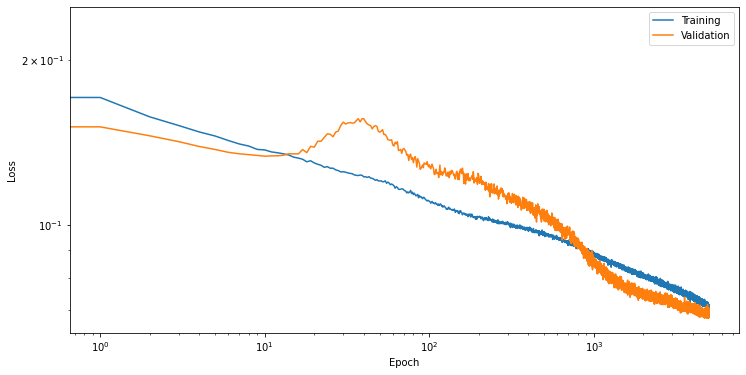

In [47]:
plot_model_loss(fit, log=True)

### Figure 1: Model loss for the training and validation set as a function of epochs. After 5000 epochs the validation loss starts to exceed the training loss. We try to not overfit the model by including dropout layers as well as not training for too many epochs. This model could probably benefit from some additional training given that these curves have not plateu'd very much yet.

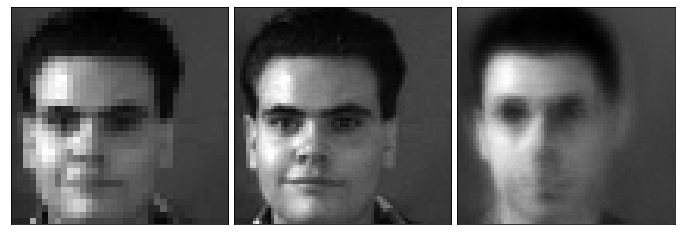

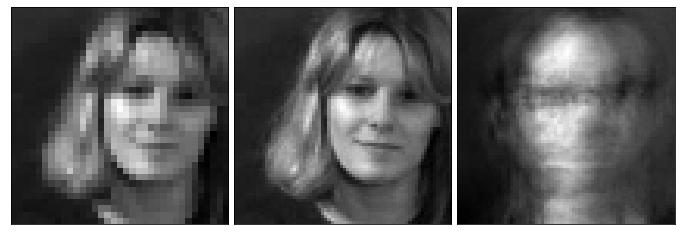

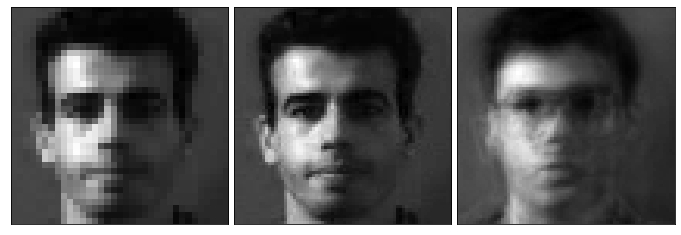

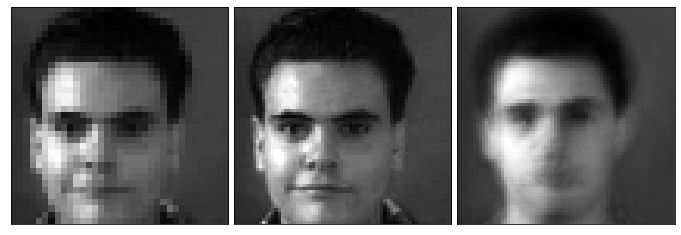

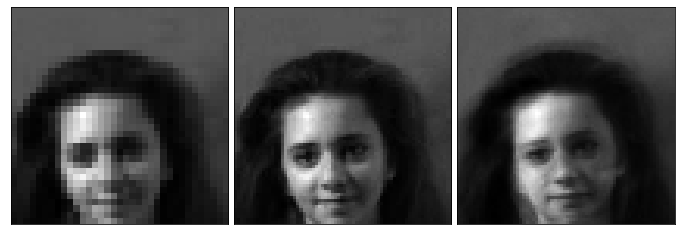

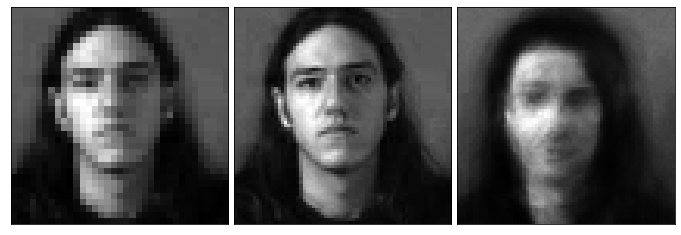

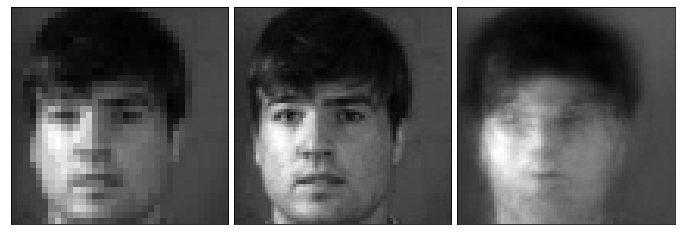

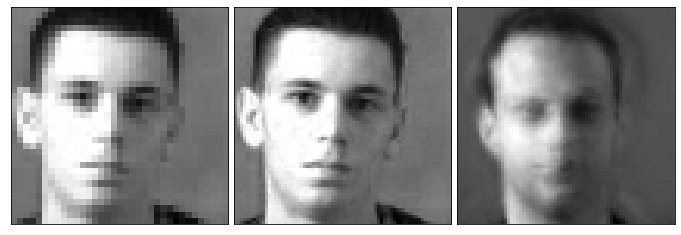

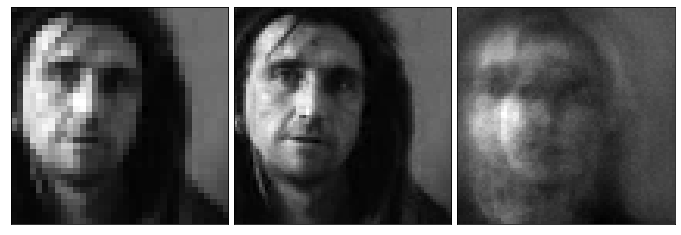

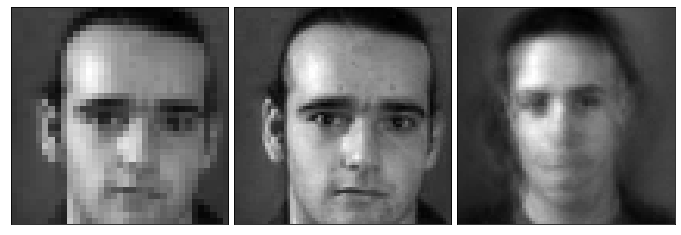

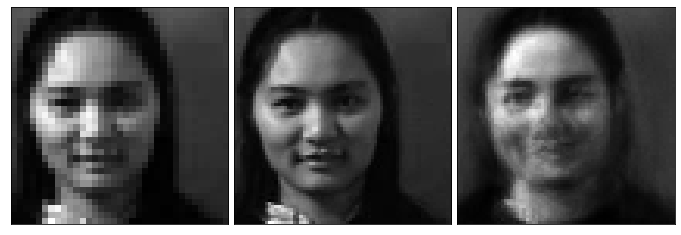

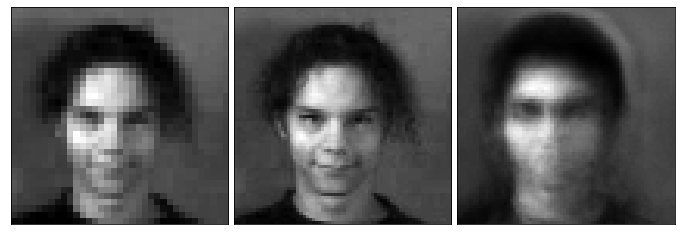

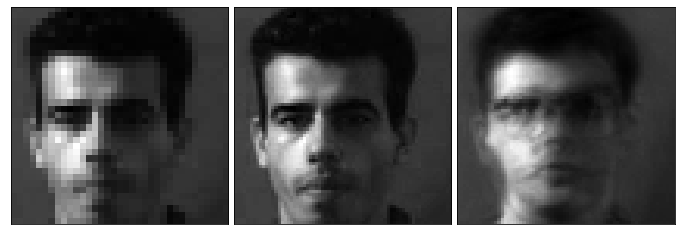

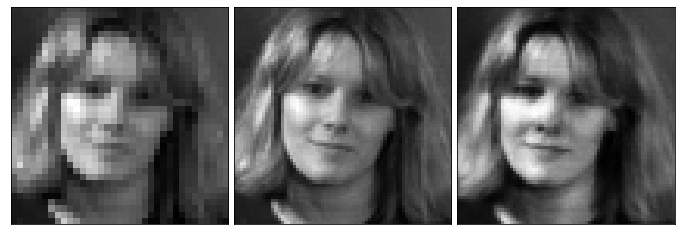

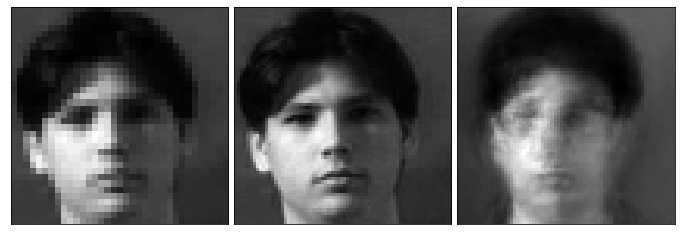

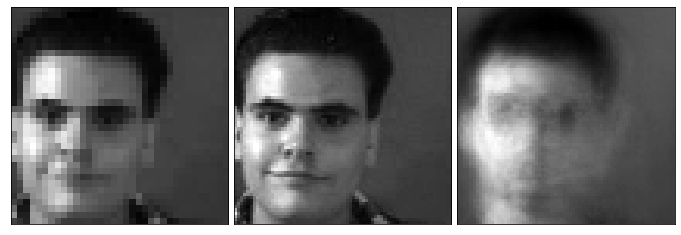

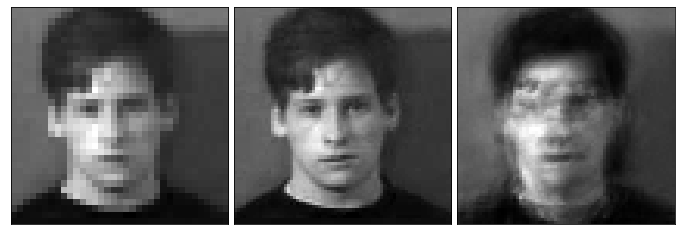

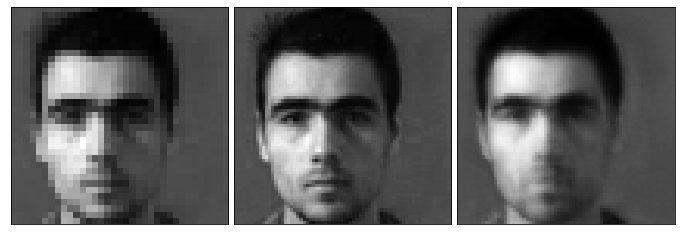

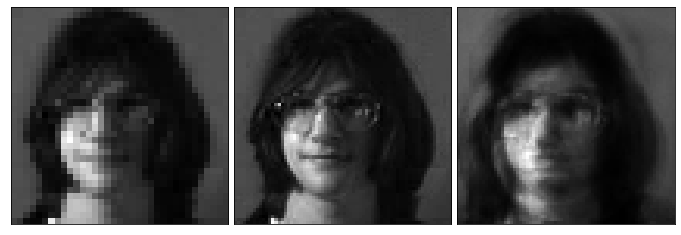

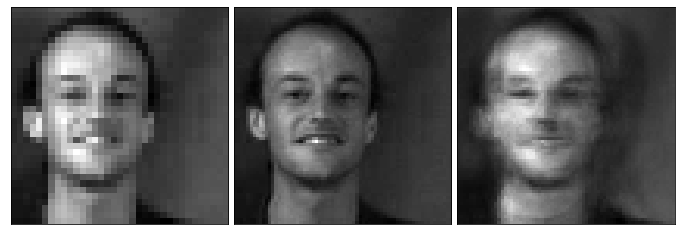

In [48]:
pred = model.predict(Xtst)
for i in range(20):
    plot_super_resolution(i, Xtst, Ytst, pred)

### Figure 2: Each row of images represents (from left to right) the low resolution training image, the high resolution target image, and the model's prediction of the high resolution image. Some perform quite well, but others look like blurs. This seems to be a combination of posterior collapse as well as some faces are not very representative of the majority of the dataset.

In [52]:
def enhance(im, model, nRow_FR=nRow_FR, nCol_FR=nCol_FR, nRow_LR=nRow_LR, nCol_LR=nCol_LR):

    im.thumbnail([nRow_FR, nCol_FR])
    im_FR = np.array(im)

    im.thumbnail([nRow_LR, nCol_LR])
    im_LR = np.array(im)

    SR = np.zeros([nRow_FR, nCol_FR, 3])
    for color_channel in [0, 1, 2]:
        im_FR_c = im_FR[:, :, color_channel].reshape(1, nRow_FR * nCol_FR) / 255
        im_LR_c = im_LR[:, :, color_channel].reshape(1, nRow_LR * nCol_LR) / 255
        SR[:, :, color_channel] = model.predict(im_LR_c).reshape(nRow_FR, nCol_FR) * 255

    SR = SR.astype(np.uint8)
    SR = Image.fromarray(SR)
    SR = SR.resize((SR.size[0] * 5, SR.size[1] * 5))
    return SR

In [57]:
fox = Image.open("/content/drive/MyDrive/Colab Notebooks/fortino_portrait.jpg")
# fox = fox.crop([0, 0, np.min(portrait.size), np.min(portrait.size)])
crop = np.percentile(range(fox.size[0]), [10, 20, 90, 100])
fox = fox.crop(box=crop)
fox.resize((fox.size[0] * 5, fox.size[1] * 5))

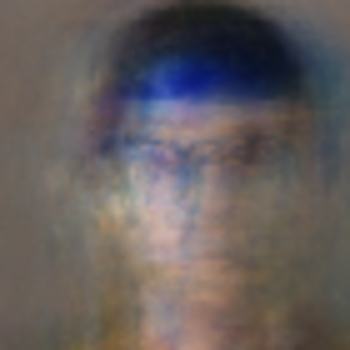

In [54]:
fox = enhance(fox, model)
fox

### Figure 3: This model does a terrible super resolution on my face. This is potentially due to my unique hairstyle which is not represented in the dataset, as well as the odd angle that I am looking at the camera.

# The cells below are just me playing around and are not a part of the homework.

In [ ]:
def grab_LR_FR_SR_mono(color_channel):
    fox = Image.open("/content/drive/MyDrive/Colab Notebooks/fortino_portrait.jpg")
    # fox = fox.crop([0, 0, np.min(portrait.size), np.min(portrait.size)])
    crop = np.percentile(range(fox.size[0]), [10, 20, 90, 100])
    fox = fox.crop(box=crop)

    fox.thumbnail([nRow_FR, nCol_FR])
    fox_FR = np.array(fox)[:, :, color_channel]

    fox.thumbnail([nRow_LR, nCol_LR])
    fox_LR = np.array(fox)[:, :, color_channel]

    fox_FR = fox_FR.reshape(1, nRow_FR * nCol_FR) / 255
    fox_LR = fox_LR.reshape(1, nRow_LR * nCol_LR) / 255
    fox_SR = model.predict(fox_LR)
    return fox_FR, fox_LR, fox_SR

In [ ]:
R_fox_FR, R_fox_LR, R_fox_SR = grab_LR_FR_SR_mono(0)
G_fox_FR, G_fox_LR, G_fox_SR = grab_LR_FR_SR_mono(1)
B_fox_FR, B_fox_LR, B_fox_SR = grab_LR_FR_SR_mono(2)

In [ ]:
R_fox_SR = R_fox_SR.reshape(nRow_FR, nCol_FR)
G_fox_SR = G_fox_SR.reshape(nRow_FR, nCol_FR)
B_fox_SR = B_fox_SR.reshape(nRow_FR, nCol_FR)

In [ ]:
img_SR = np.dstack((R_fox_SR, G_fox_SR, B_fox_SR)) * 255
img_SR = img_SR.astype(np.uint8)

In [ ]:
img_SR.min(), img_SR.max()

(3, 247)

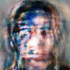

In [ ]:
fox_SR = Image.fromarray(img_SR)
fox_SR

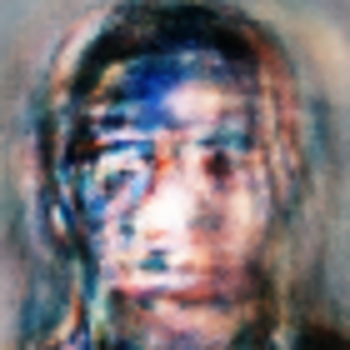

In [ ]:
fox_SR = fox_SR.resize((fox_SR.size[0] * 5, fox_SR.size[1] * 5))
fox_SR

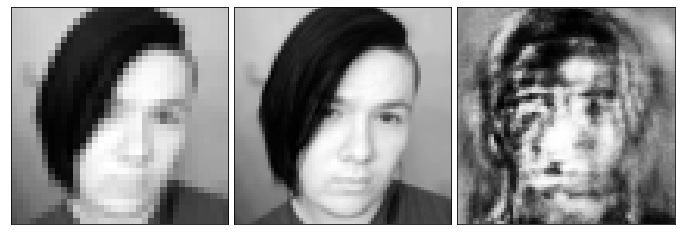

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(12, 4))
plt.subplots_adjust(hspace=0, wspace=0)

axes[0].imshow(R_fox_LR.reshape(nRow_LR, nCol_LR), cmap=plt.cm.gray)
axes[1].imshow(R_fox_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.gray)
axes[2].imshow(R_fox_SR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.gray)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

plt.show()

In [ ]:
def grab_LR_FR_SR_mono_GRACE(color_channel):
    grace = Image.open("/content/drive/MyDrive/Colab Notebooks/grace.jpeg")
    # grace = grace.crop([0, 0, np.min(portrait.size), np.min(portrait.size)])
    crop = np.percentile(range(grace.size[1]), [30, 70]).astype(int)
    grace = grace.crop(box=[100, crop[0], grace.size[0] - 200, crop[1] - 11])

    grace.thumbnail([nRow_FR, nCol_FR])
    grace_FR = np.array(grace)[:, :, color_channel]

    grace.thumbnail([nRow_LR, nCol_LR])
    grace_LR = np.array(grace)[:, :, color_channel]

    grace_FR = grace_FR.reshape(1, nRow_FR * nCol_FR) / 255
    grace_LR = grace_LR.reshape(1, nRow_LR * nCol_LR) / 255
    grace_SR = model.predict(grace_LR)
    return grace_FR, grace_LR, grace_SR

In [ ]:
R_grace_FR, R_grace_LR, R_grace_SR = grab_LR_FR_SR_mono_GRACE(0)
G_grace_FR, G_grace_LR, G_grace_SR = grab_LR_FR_SR_mono_GRACE(1)
B_grace_FR, B_grace_LR, B_grace_SR = grab_LR_FR_SR_mono_GRACE(2)

R_grace_SR = R_grace_SR.reshape(nRow_FR, nCol_FR)
G_grace_SR = G_grace_SR.reshape(nRow_FR, nCol_FR)
B_grace_SR = B_grace_SR.reshape(nRow_FR, nCol_FR)

img_SR = np.dstack((R_grace_SR, G_grace_SR, B_grace_SR)) * 255
img_SR = img_SR.astype(np.uint8)

In [ ]:
grace_SR = Image.fromarray(img_SR)
grace_SR = grace_SR.resize((grace_SR.size[0] * 5, grace_SR.size[1] * 5))

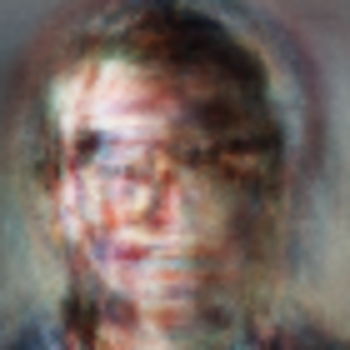

In [ ]:
grace_SR

In [ ]:
grace_SR.save("/content/drive/MyDrive/Colab Notebooks/grace_fuckedup2.png")

In [ ]:
fox_SR.save("/content/drive/MyDrive/Colab Notebooks/fox_fuckedup2.png")

In [ ]:
!rm grace_fuckedup.png

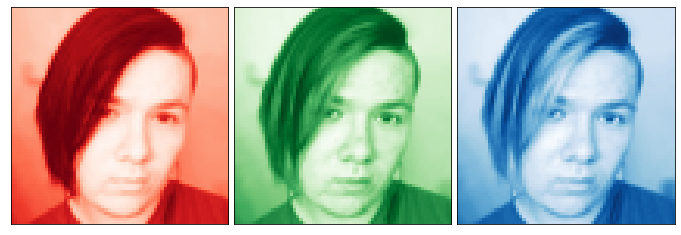

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(12, 4))
plt.subplots_adjust(hspace=0, wspace=0)

axes[0].imshow(R_fox_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.Reds_r)
axes[1].imshow(G_fox_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.Greens_r)
axes[2].imshow(B_fox_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.Blues_r)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

plt.show()

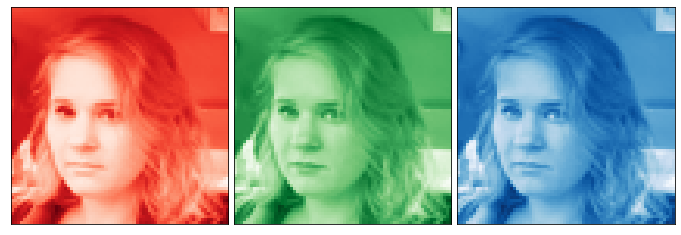

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(12, 4))
plt.subplots_adjust(hspace=0, wspace=0)

axes[0].imshow(R_grace_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.Reds_r)
axes[1].imshow(G_grace_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.Greens_r)
axes[2].imshow(B_grace_FR.reshape(nRow_FR, nCol_FR), cmap=plt.cm.Blues_r)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

plt.show()

In [ ]:
f_arr = np.array(fox_SR)
g_arr = np.array(grace_SR)

combine = (f_arr + g_arr)
combine[combine > 255] = 255
combine = Image.fromarray(combine.astype(np.uint8))

In [ ]:
import astropy

In [ ]:
from astropy import convolution

In [ ]:
k = convolution.Gaussian2DKernel(5, 5)
convr = convolution.convolve_fft(np.array(combine)[:, :, 0], k)
convg = convolution.convolve_fft(np.array(combine)[:, :, 1], k)
convb = convolution.convolve_fft(np.array(combine)[:, :, 2], k)
conv = np.dstack((convr, convg, convb))

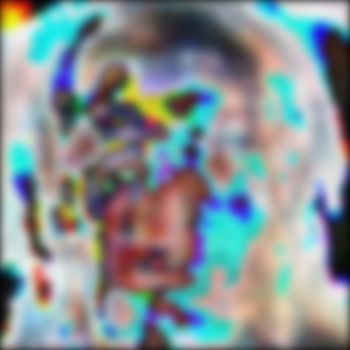

In [ ]:
conv = Image.fromarray(conv.astype(np.uint8))
conv

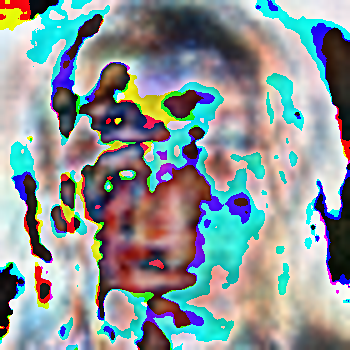

In [ ]:
combine

---

<h1 style="color:red"> Awesome !</h1>
